In [195]:
import sys; sys.path.append('..')
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# dataset = 'sun'
# data_dir = f'/tmp/skoroki/czsl/{dataset}_feats'
# attrs_file_path = '/tmp/skoroki/czsl/data/CUB_200_2011/attributes/class_attribute_labels_continuous.txt'

# attrs = open(attrs_file_path).read().splitlines()
# attrs = np.array([[float(x) for x in line.split()] for line in attrs])
# feats = np.load(feats_file_path)

# attrs = torch.from_numpy(attrs.astype(np.float32))

# attrs = attrs / attrs.norm(dim=1, keepdim=True)

datasets = ['SUN', 'CUB', 'AwA1', 'AwA2', 'aPY']

def load_np_data(dataset: str, filename: str):
    filepath = f'/tmp/skoroki/czsl/data/{dataset.lower()}_feats/{filename}.npy'
    data = np.load(filepath)
    data = torch.from_numpy(data.astype(np.float32))
    
    return data

def load_attrs(dataset: str):
    return load_np_data(dataset, 'attrs')

def load_feats(dataset):
    return load_np_data(dataset, 'feats')

In [167]:
def compute_variances(dataset: str, batch_size: int=512):
    attrs = load_attrs(dataset)
    feats = load_feats(dataset)
    
    #attrs = attrs / attrs.norm(dim=1, keepdim=True)
    
    model = nn.Sequential(
        nn.Linear(attrs.shape[1], 512),
        nn.ReLU(),
        nn.Linear(512, feats.shape[1]),
        #nn.ReLU(),
    )
    
    with torch.no_grad():
        protos = model(attrs)
        protos = protos / protos.norm(dim=1, keepdim=True)
        feats = feats / feats.norm(dim=1, keepdim=True)
    
    logits = [(feats[i:i+batch_size] @ protos.t()) for i in range(0, len(feats), batch_size)]
    variances = torch.stack([l.var(dim=0) for l in logits]).view(-1)
    
    return variances


predicted_var = lambda d: d / ((d - 2) ** 2)
predicted_std = lambda d: np.sqrt(predicted_var(d))

In [169]:
from tqdm import tqdm

# batch_sizes = [256, 512, 1024, 4096, 8192]
# variances = [[compute_variances(d, b) for d in datasets] for b in tqdm(batch_sizes)]
# variances_mean = [[v.sqrt().mean() for v in vs] for vs in variances]
# variances_std = [[v.sqrt().std() for v in vs] for vs in variances]
batch_size = 4096
variances = [compute_variances(d, batch_size) for d in datasets]
variances_mean = torch.tensor([v.mean() for v in variances])
variances_std = torch.tensor([v.std() for v in variances])

In [251]:
plt.rcParams.update({'font.size': 12})

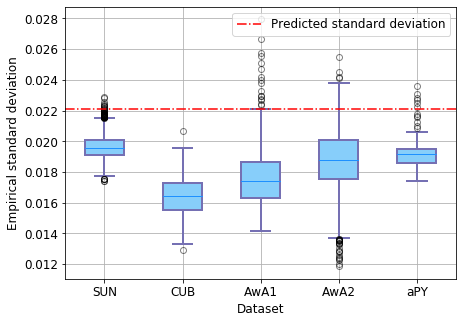

In [254]:
plt.figure(figsize=(7, 5))
bp = plt.boxplot([v.sqrt().tolist() for v in variances], patch_artist=True);
plt.plot([0.5,5.5], [predicted_std(2048), predicted_std(2048)],
         color='red', lineStyle='-.', label='Predicted standard deviation')

for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = 'lightskyblue' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='dodgerblue', linewidth=1)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

plt.grid();
plt.xlabel('Dataset')
plt.ylabel('Empirical standard deviation')
plt.xticks(np.arange(len(datasets)) + 1, datasets);
plt.legend()
plt.savefig(f'../plots/empirical-validation.pdf', bbox_inches = 'tight', pad_inches = 0)

In [258]:
def compute_syntetic_std(dim: int, batch_size=256):
    x = torch.randn(batch_size, dim)
    y = torch.randn(batch_size, dim)
    x = x / x.norm(dim=1, keepdim=True)
    y = y / y.norm(dim=1, keepdim=True)
    logits = x @ y.t()
    stds = logits.std(dim=1)
    
    return stds.mean(), stds.std()

dims = [2 ** k for k in range(5, 14)]
stds_mean, stds_std = zip(*[compute_syntetic_std(d) for d in dims])
stds_mean, stds_std = np.array(stds_mean), np.array(stds_std)
std_predicted = [predicted_std(d) for d in dims]

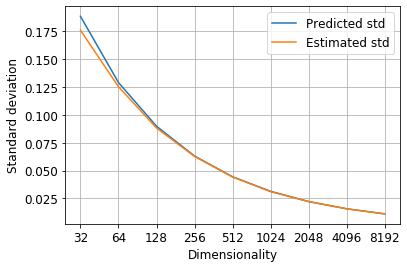

In [264]:
plt.plot(std_predicted, label='Predicted std')
plt.plot(stds_mean, label='Estimated std')
# plt.fill_between(np.arange(len(stds_mean)), stds_mean - stds_std, stds_mean + stds_std, alpha=.1)
plt.xticks(np.arange(len(dims)), dims)
plt.grid()
plt.xlabel('Dimensionality')
plt.ylabel('Standard deviation')
plt.legend();
plt.savefig(f'../plots/empirical-validation-synthetic.pdf', bbox_inches = 'tight', pad_inches = 0)